In [1]:
import pandas as pd
import numpy as np
import random
import pickle
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:

import matplotlib.pyplot as plt
import pickle
import heapq

In [4]:
text_df = pd.read_csv("MiniProject-train.csv")

In [5]:
text_df

,Unnamed: 0,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3
2,2,anetv_jkn6uvmqwh4,3415,A group of members in green uniforms walks wav...,A group of members in green uniforms walks wav...,Members of the procession,gold,pay the other coaches to cheer as people this ...,walk down the street holding small horn brass ...,is seen in the background.,are talking a couple of people playing a game ...,1
3,3,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,makes a square call and ends by jumping down i...,play and go back and forth hitting the drums w...,3
4,4,anetv_Bri_myFFu4A,2408,The person plays a song on the violin. The man,The person plays a song on the violin.,The man,gold,finishes the song and lowers the instrument.,hits the saxophone and demonstrates how to pro...,finishes massage the instrument again and cont...,continues dancing while the man gore the music...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
73541,73541,lsmdc3073_THE_GUILT_TRIP-34734,2708,Someone bites her lower lip. Someone,Someone bites her lower lip.,Someone,gen,shifts her thoughtful gaze to the page.,sits down next to her on the bed.,"pats chin, looks down.",gives him a disapproving look.,1
73542,73542,anetv_R2izNBHhctM,62,The cat looked up while the woman is clipping ...,The cat looked up while the woman is clipping ...,"While the woman is clipping the left back paw,...",gen,appears on the left youth.,is overlaid on the nail.,zooms out holding her toothbrush.,stands in her lap as it moves away from her le...,3
73543,73543,anetv_R2izNBHhctM,60,A woman in pink dress is clipping the right pa...,A woman in pink dress is clipping the right pa...,"She took the left paw to clip, the cat looked ...",gold,is brushing on the wall with two toys.,gave them a bit and placed unto the cat's back.,looked down and gave her a quick kiss on the h...,drops the smooths it on the other side of the ...,2
73544,73544,anetv_R2izNBHhctM,62,The cat looked up while the woman is clipping ...,The cat looked up while the woman is clipping ...,"While the woman is clipping the left back paw,...",gold,was blinking to the camera.,is overlaid on the nail.,appears on the left youth.,zooms out holding her toothbrush.,0


In [6]:
for label_val in text_df['label']:
  if label_val == 0:
    text_df['sent'] = text_df['startphrase'] + " " + text_df['ending0']
  elif label_val == 1:
    text_df['sent'] = text_df['startphrase'] + " " + text_df['ending1']
  elif label_val == 2:
    text_df['sent'] = text_df['startphrase'] + " " + text_df['ending2']
  elif label_val == 3:
    text_df['sent'] = text_df['startphrase'] + " " + text_df['ending3']

In [7]:
text_df['sent'][0]

'Members of the procession walk down the street holding small horn brass instruments. A drum line has heard approaching them.'

In [8]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73546 entries, 0 to 73545
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   73546 non-null  int64 
 1   video-id     73546 non-null  object
 2   fold-ind     73546 non-null  int64 
 3   startphrase  73546 non-null  object
 4   sent1        73546 non-null  object
 5   sent2        73546 non-null  object
 6   gold-source  73546 non-null  object
 7   ending0      73546 non-null  object
 8   ending1      73546 non-null  object
 9   ending2      73546 non-null  object
 10  ending3      73546 non-null  object
 11  label        73546 non-null  int64 
 12  sent         73546 non-null  object
dtypes: int64(3), object(10)
memory usage: 7.3+ MB


In [9]:
swag_text = list(text_df.sent.values)
partial_text = swag_text[:5000]
joined_text = " ".join(partial_text)
joined_text = joined_text.lower()

In [10]:
len(set(list(joined_text.split())))

9102

In [10]:
len(joined_text)

608946

## BERT 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\ProgramData\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 0.5098954439163208
Epoch 2/3, Loss: 0.2879583537578583
Epoch 3/3, Loss: 0.1619165539741516


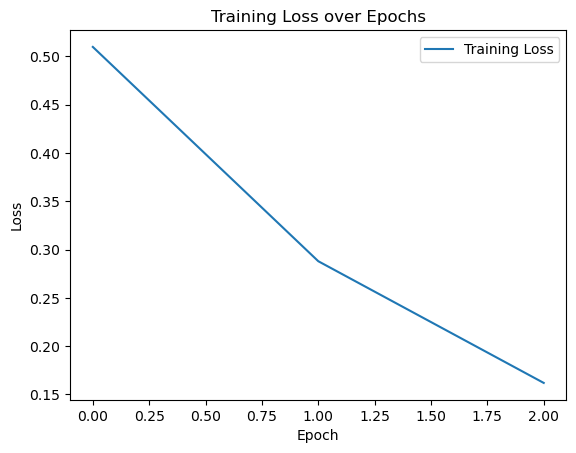

NameError: name 'validation_dataloader' is not defined

In [31]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import matplotlib.pyplot as plt

# Step 1: Prepare Your Data
# TODO: Load and preprocess your training data

# Step 2: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_data = tokenizer(joined_text, truncation=True, padding=True, return_tensors='pt')

# Step 3: Create Input Sequences for MLM
input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']
labels = input_ids.clone()  # Labels are the same as input_ids for MLM task

# Mask some tokens for MLM training
probability_matrix = torch.rand(input_ids.shape)
masking_prob = probability_matrix < 0.15  # You can adjust this masking probability
input_ids[masking_prob] = tokenizer.mask_token_id

# Step 4: Create DataLoader
dataset = TensorDataset(input_ids, attention_mask, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Step 5: Initialize and Train BERT for MLM
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
'''num_epochs = 3
losses = []

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}")

# Plot the loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()
'''
num_epochs = 3
losses = []

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_losses.append(loss.item())

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}")

# Plot the loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Evaluate accuracy (assuming a validation set is available)
# Note: This is just a placeholder and should be adapted based on your task
'''model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in validation_dataloader:  # Assuming you have a separate validation dataloader
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        logits = outputs.logits
        predictions = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
        correct_predictions += torch.sum(predictions == labels_batch).item()
        total_predictions += labels_batch.numel()

accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {accuracy}")

# Optionally, plot the accuracy over epochs
accuracies = [accuracy] * num_epochs
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()
# Optionally, plot the accuracy over epochs
# Note: Since this is a generative task, accuracy might not be a well-defined metric
# Consider using perplexity or other evaluation metrics specific to language modeling tasks.
'''



Validation Accuracy: 0.986328125


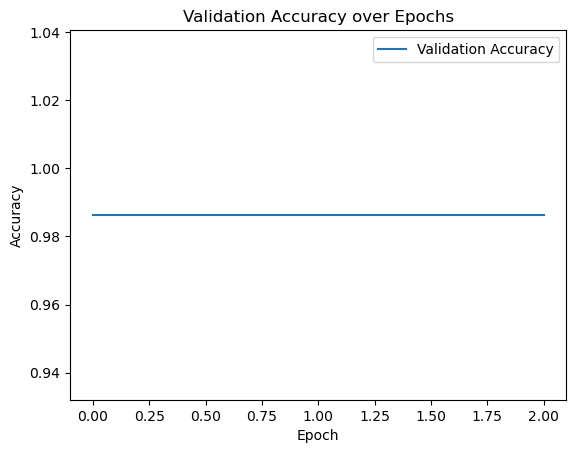

In [33]:
model.eval()
correct_predictions = 0
total_predictions = 0

# Assuming you have a separate validation dataloader
validation_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        logits = outputs.logits
        predictions = torch.argmax(torch.nn.functional.softmax(logits, dim=-1), dim=-1)
        correct_predictions += torch.sum(predictions == labels_batch).item()
        total_predictions += labels_batch.numel()

accuracy = correct_predictions / total_predictions
print(f"Validation Accuracy: {accuracy}")

# Optionally, plot the accuracy over epochs
accuracies = [accuracy] * num_epochs
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Save the trained model
model.save_pretrained('bert-next-word-prediction')

In [35]:
model.save_pretrained('bert-next-word-prediction.h5')

## Integrating GUI

In [40]:
pip install transformers torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [48]:
'''import tkinter as tk
from tkinter import scrolledtext
from transformers import BertTokenizer, BertForMaskedLM
import torch

class NextWordPredictionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Next Word Prediction")

        self.create_widgets()

        # Load BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertForMaskedLM.from_pretrained('bert-base-uncased')
        self.model.eval()

    def create_widgets(self):
        self.input_text = scrolledtext.ScrolledText(self.root, width=40, height=10)
        self.input_text.pack(pady=10)

        self.predict_button = tk.Button(self.root, text="Predict Next Word", command=self.predict_next_word)
        self.predict_button.pack(pady=10)

        self.output_label = tk.Label(self.root, text="Next Word Prediction:")
        self.output_label.pack()

    def predict_next_word(self):
        input_text = self.input_text.get("1.0", tk.END).strip()

        if input_text:
            # Tokenize input text
            tokenized_text = self.tokenizer.encode(input_text, add_special_tokens=True, return_tensors='pt')

            # Find the position of the mask token
            mask_token_index = (tokenized_text[0] == self.tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
            
            if mask_token_index.numel() > 0:
                # Mask the found mask token for next-word prediction
                tokenized_text[0, mask_token_index] = self.tokenizer.mask_token_id

                # Generate predictions
                with torch.no_grad():
                    predictions = self.model(tokenized_text)[0]

                # Get the predicted next word
                predicted_index = torch.argmax(predictions[0, mask_token_index]).item()
                predicted_word = self.tokenizer.decode([predicted_index])

                # Display the prediction
                self.output_label.config(text=f"Next Word Prediction: {predicted_word}")
            else:
                self.output_label.config(text="Error: Mask token not found in input.")

if __name__ == "__main__":
    root = tk.Tk()
    app = NextWordPredictionApp(root)
    root.mainloop()
'''

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
import tkinter as tk
from tkinter import scrolledtext
from transformers import BertTokenizer, BertForMaskedLM
import torch

class NextWordPredictionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Next Sentence Prediction")

        self.create_widgets()

        # Load BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertForMaskedLM.from_pretrained('bert-base-uncased')
        self.model.eval()

    def create_widgets(self):
        self.input_text = scrolledtext.ScrolledText(self.root, width=40, height=10)
        self.input_text.pack(pady=10)

        # Entry for user to input the value of k
        self.k_entry = tk.Entry(self.root, width=5)
        self.k_entry.pack(pady=5)
        self.k_entry.insert(0, "5")  # Default value is 5

        self.predict_button = tk.Button(self.root, text="Predict Top Words", command=self.predict_top_words)
        self.predict_button.pack(pady=10)

        self.output_label = tk.Label(self.root, text="Top Predicted Words:")
        self.output_label.pack()

    def predict_top_words(self):
        input_text = self.input_text.get("1.0", tk.END).strip()
        k = int(self.k_entry.get())

        if input_text:
            # Tokenize input text
            tokenized_text = self.tokenizer.encode(input_text, add_special_tokens=True, return_tensors='pt')

            # Find the position of the mask token
            mask_token_index = (tokenized_text[0] == self.tokenizer.mask_token_id).nonzero(as_tuple=True)

            if mask_token_index[0].numel() > 0:
                mask_token_index = mask_token_index[0][0].item()

                # Mask the found mask token for next-word prediction
                tokenized_text[0, mask_token_index] = self.tokenizer.mask_token_id

                # Generate predictions
                with torch.no_grad():
                    predictions = self.model(tokenized_text)[0]

                # Get the top k predicted words
                top_k_indices = torch.topk(predictions[0, mask_token_index], k).indices.tolist()
                top_k_words = [self.tokenizer.decode([index]) for index in top_k_indices]

                # Display the top k predicted words
                self.output_label.config(text=f"Top Predicted Words: {', '.join(top_k_words)}")
            else:
                self.output_label.config(text="Error: [MASK] token not found in input.")

if __name__ == "__main__":
    root = tk.Tk()
    app = NextWordPredictionApp(root)
    root.mainloop()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## RNN LSTM

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Sample text data
text_data = joined_text

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for line in text_data.split('.'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Build the model
lstm_model = Sequential()
lstm_model.add(Embedding(total_words, 50, input_length=max_sequence_length - 1))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(total_words, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X, y, epochs=30, verbose=1)



Epoch 1/30
3199/3199 [==============================] - 204s 63ms/step - loss: 5.9976 - accuracy: 0.1117
Epoch 2/30
3199/3199 [==============================] - 218s 68ms/step - loss: 5.1045 - accuracy: 0.1690
Epoch 3/30
3199/3199 [==============================] - 213s 67ms/step - loss: 4.6742 - accuracy: 0.1969
Epoch 4/30
3199/3199 [==============================] - 239s 75ms/step - loss: 4.3460 - accuracy: 0.2182
Epoch 5/30
3199/3199 [==============================] - 276s 86ms/step - loss: 4.0739 - accuracy: 0.2374
Epoch 6/30
3199/3199 [==============================] - 252s 79ms/step - loss: 3.8329 - accuracy: 0.2614
Epoch 7/30
3199/3199 [==============================] - 249s 78ms/step - loss: 3.6154 - accuracy: 0.2857
Epoch 8/30
3199/3199 [==============================] - 275s 86ms/step - loss: 3.4214 - accuracy: 0.3113
Epoch 9/30
3199/3199 [==============================] - 258s 81ms/step - loss: 3.2438 - accuracy: 0.3364
Epoch 10/30
3199/3199 [==============================] 

In [17]:
# Generate text given a seed sequence
seed_text = input("Enter text: ")
n = int(input("Enter no.of words to be generated: "))

for _ in range(n):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted = np.argmax(lstm_model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

Enter text: It is hard to believe that
Enter no.of words to be generated: 5
1/1 [==============================] - 0s 71ms/step
It is hard to believe that someone who is swimming inside


## N-Gram model

In [ ]:
import matplotlib.pyplot as plt

# Sample text data
text_data = joined_text

# Tokenize the text
tokens = text_data.split()

# Create bigrams
ngrams_data = list(ngrams(tokens, 2))

# Create a defaultdict to store predicted word frequencies
predicted_frequencies = defaultdict(int)
for prefix, next_word in ngrams_data:
    predicted_frequencies[next_word] += 1

# Plot the frequencies
words, frequencies = zip(*sorted(predicted_frequencies.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Next Word')
plt.ylabel('Frequency')
plt.title('Top Predicted Next Words in N-gram Model')
plt.show()


## GRU model

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Sample text data
text_data = joined_text

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for line in text_data.split('.'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Build the model
gru_model = Sequential()
gru_model.add(Embedding(total_words, 50, input_length=max_sequence_length - 1))
gru_model.add(GRU(100))
gru_model.add(Dense(total_words, activation='softmax'))

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.fit(X, y, epochs=30, verbose=1)



Epoch 1/30
3199/3199 [==============================] - 261s 81ms/step - loss: 5.8175 - accuracy: 0.1238
Epoch 2/30
3199/3199 [==============================] - 271s 85ms/step - loss: 4.9284 - accuracy: 0.1807
Epoch 3/30
3199/3199 [==============================] - 212s 66ms/step - loss: 4.4553 - accuracy: 0.2110
Epoch 4/30
3199/3199 [==============================] - 231s 72ms/step - loss: 4.0850 - accuracy: 0.2413
Epoch 5/30
3199/3199 [==============================] - 203s 63ms/step - loss: 3.7686 - accuracy: 0.2742
Epoch 6/30
3199/3199 [==============================] - 166s 52ms/step - loss: 3.4944 - accuracy: 0.3089
Epoch 7/30
3199/3199 [==============================] - 218s 68ms/step - loss: 3.2560 - accuracy: 0.3424
Epoch 8/30
3199/3199 [==============================] - 234s 73ms/step - loss: 3.0475 - accuracy: 0.3742
Epoch 9/30
3199/3199 [==============================] - 210s 66ms/step - loss: 2.8629 - accuracy: 0.4050
Epoch 10/30
3199/3199 [==============================] 

In [28]:
# Generate text given a seed sequence
seed_text = input("Enter text: ")
next_words = int(input("Enter no.of words to be generated: "))

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted = np.argmax(gru_model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)


Enter text: Dont trouble the trouble if you trouble the trouble trouble troubles you i am not the trouble
Enter no.of words to be generated: 5
1/1 [==============================] - 0s 23ms/step
Dont trouble the trouble if you trouble the trouble trouble troubles you i am not the trouble man in front of his


## ROBERTA

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.nn import CrossEntropyLoss
from tqdm import tqdm


# Tokenize the text
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
input_ids = tokenizer.encode(joined_text, return_tensors='pt', truncation=True, padding=True)

# Create labels (let's assume binary classification for simplicity)
# Replace this with your task-specific labels
labels = torch.tensor([0] * input_ids.shape[0])  # Assuming 0 for all samples

# Create a DataLoader
dataset = TensorDataset(input_ids, labels)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.train()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

# Training loop
num_epochs = 30  # Set to 30 epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    total_steps = 0

    for batch in tqdm(data_loader, desc=f"Epoch {epoch + 1}"):
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        total_steps += 1

        loss.backward()
        optimizer.step()

    average_loss = total_loss / total_steps
    print(f'Epoch {epoch + 1}, Loss: {average_loss}')

# Save the fine-tuned model if needed
model.save_pretrained('fine_tuned_roberta')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Epoch 1, Loss: 0.6957700252532959


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.18s/it]


Epoch 2, Loss: 0.6576586365699768


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:55<00:00, 115.25s/it]


Epoch 3, Loss: 0.6325362920761108


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:45<00:00, 105.06s/it]


Epoch 4, Loss: 0.5905188918113708


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.24s/it]


Epoch 5, Loss: 0.5120791792869568


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.61s/it]


Epoch 6, Loss: 0.5694156885147095


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.65s/it]


Epoch 7, Loss: 0.40158265829086304


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.60s/it]


Epoch 8, Loss: 0.41303107142448425


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.53s/it]


Epoch 9, Loss: 0.5126968622207642


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.49s/it]


Epoch 10, Loss: 0.4950035810470581


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.67s/it]


Epoch 11, Loss: 0.43202030658721924


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.19s/it]


Epoch 12, Loss: 0.4701085388660431


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.82s/it]


Epoch 13, Loss: 0.15057216584682465


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.64s/it]


Epoch 14, Loss: 0.33756399154663086


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.34s/it]


Epoch 15, Loss: 0.34358325600624084


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:39<00:00, 99.08s/it]


Epoch 16, Loss: 0.30195310711860657


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:42<00:00, 102.46s/it]


Epoch 17, Loss: 0.3081834316253662


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.45s/it]


Epoch 18, Loss: 0.21518146991729736


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.99s/it]


Epoch 19, Loss: 0.1407160758972168


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:43<00:00, 103.07s/it]


Epoch 20, Loss: 0.10909205675125122


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.67s/it]


Epoch 21, Loss: 0.09377989917993546


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [03:45<00:00, 225.68s/it]


Epoch 22, Loss: 0.060333091765642166


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [03:44<00:00, 224.88s/it]


Epoch 23, Loss: 0.08339738100767136


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [14:30<00:00, 870.40s/it]


Epoch 24, Loss: 0.07258326560258865


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.25s/it]


Epoch 25, Loss: 0.04330955073237419


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.24s/it]


Epoch 26, Loss: 0.034207530319690704


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.60s/it]


Epoch 27, Loss: 0.02144762873649597


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.78s/it]


Epoch 28, Loss: 0.029483890160918236


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.74s/it]


Epoch 29, Loss: 0.02480783686041832


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.04s/it]


Epoch 30, Loss: 0.02923789992928505
